# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction;<br/>
4) **Visulization**: network illustration.<br/>

[scanpy](https://scanpy.readthedocs.io/en/stable/) is a python toolkit for single cell transcriptomics data analysis. Beyonds mainstream analysis on cell behaviors, PySCNet integrates diverse network inference methods to build gene regulatory networks (GRNs) and provides graph based techniques to summarize the strength of regulatory interactions, which can be uploaded onto an interactive web-based dashboard.

This tutorial guides you 1) build cell specific gene regulatory network; 2) predict consensus network; 3) Identify cell specific transcription factors and 4) network visualization.

In [3]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 

from pyscnet import Preprocessing as pp
from pyscnet import BuildNet as bn
from pyscnet import NetEnrich as ne
from pyscnet import Plotting as pl
pd.set_option('display.max_rows', 1000)

scanpy==1.5.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


### Data resource
PBMC data preprocessed and analyzed by scanpy as explained in [this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). pyscnet provides an interface which converts processed [AnnData](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) from scanpy into gnetData.

In [4]:
import _pickle as pk
with open('tutorial_data/pyscnet_scanpy_pbmc/scanpy_obj.pk', 'rb') as input:
    adata = pk.load(input)

### Analysis results from scanpy
As shown below, there are 8 cell types detected by scanpy.

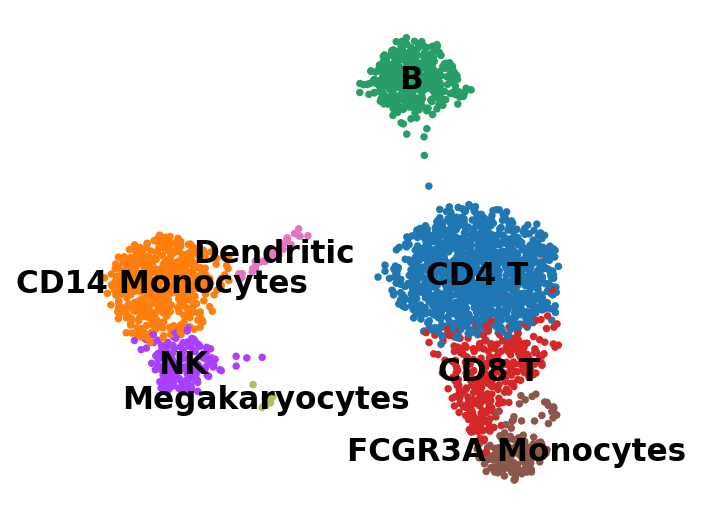

In [5]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

Choose top 50 marker genes for each cell type

In [6]:
sc.tl.rank_genes_groups(adata, groupby='leiden',n_genes=50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


### Preprocessing: Import scanpy object into PySCNet


In [7]:
#import from local pickle
scanpy_gne = pp.load_from_anndata(adata)
#export from scanpy_pbmc https://github.com/MingBit/PySCNet/blob/master/tutorial/scanpy_pbmc.ipynb
scanpy_gne.info

Gnetdata object with 
ExpMatrix: 1838 x 2638
CellAttrs:dict_keys(['CellInfo'])
GeneAttrs:dict_keys(['GeneInfo'])
NetAttrs:dict_keys(['parameters'])


As clustering analysis was performed based on highly variable genes, we need to go back to the full gene list to select ranked mark genes.

In [8]:
adata_2 = adata.raw.to_adata()
sc.pp.regress_out(adata_2, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_2, max_value=10)

scanpy_gne.ExpMatrix = pd.DataFrame(data=adata_2.X, index=adata_2.obs_names, columns=adata_2.var_names).T
scanpy_gne.info

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:32)
Gnetdata object with 
ExpMatrix: 13714 x 2638
CellAttrs:dict_keys(['CellInfo'])
GeneAttrs:dict_keys(['GeneInfo'])
NetAttrs:dict_keys(['parameters'])


### Cell count barplot

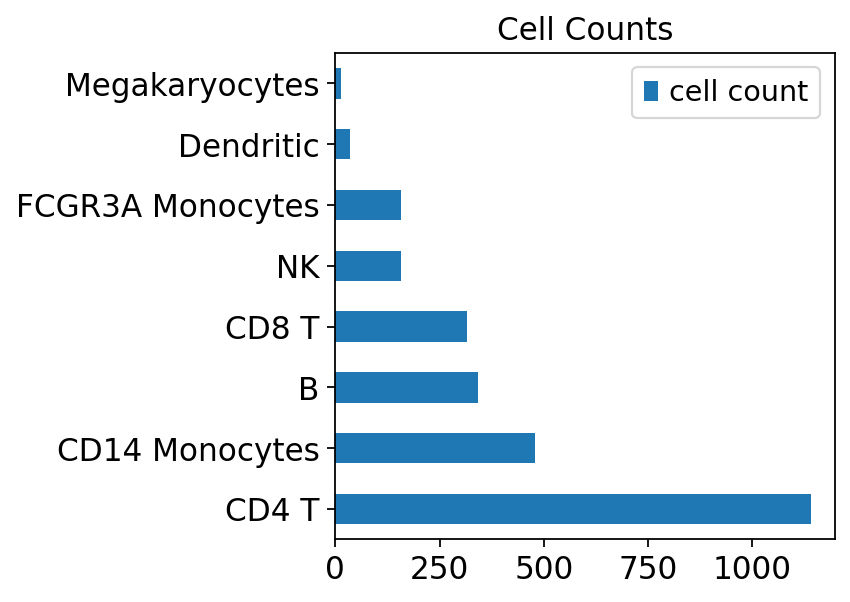

In [9]:
cell_count = pd.DataFrame(scanpy_gne.CellAttrs['CellInfo'].leiden.value_counts())
cell_count.columns = ['cell count']
cell_count.plot(kind='barh', title='Cell Counts', mark_right=True)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='cell count')
plt.grid(b=None)
# plt.savefig('tutorial_data/pyscnet_scanpy_pbmc/Cell_Count.pdf', dpi=300, bbox_inches='tight')

### Feature selection for each cell type
It is important to pre-select features for creating gene regulatory network as there is less sense of including low expressed genes. To do so, top ranked markers genes of cell sub-populations are selected for GRN construction.

In [10]:
# the union set of marker genes from the following 4 cell types
cells = ['B','CD4 T', 'CD8 T', 'CD14 Monocytes']
Features = list()
for cell in cells:
    Features += list(adata.uns['rank_genes_groups']['names'][cell])

Features = list(set(Features) & set(scanpy_gne.ExpMatrix.index))
len(Features)


191

Among selected features, 6 transcription factors are included.

In [11]:
Mms = pd.read_csv('../Mus_TF_and_TFcofactor/Mus_musculus_TF.txt', sep='\t')
Mms.Symbol = [x.upper() for x  in Mms.Symbol]
TFs = list(set(Features) & set(Mms.Symbol))
TFs

['SPI1', 'LYAR', 'IRF8', 'CEBPD', 'SPIB', 'HOPX']

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were concluded as competitive tools in terms of reconstructing GRNs from curated models and experimental datasets. but the outcomes yielded from different methods are largely irreconcilable. Therefore, defining a consensus network from multiple network becomes essential for the downstream analysis.

In [10]:
methods_list = ['PIDC','GENIE3', 'GRNBOOST2', 'phase_synchrony']
file_path = 'tutorial_data/pyscnet_scanpy_pbmc/'

for cell in cells:
        
    for method in methods_list:
        if method in ['window_rolling', 'phase_synchrony']:
            scanpy_gne = bn.get_synchrony(scanpy_gne.deepcopy, method=method,
                                          feature=Features, cell_clusterid=cell, select_by='leiden')
        else:
            scanpy_gne = bn.rundocker(scanpy_gne.deepcopy, method=method,
                                          feature=Features, cell_clusterid=cell, select_by='leiden', directed=False)

    scanpy_gne.save_as(file_path + cell + '_gne.pk')

PIDC_links added into NetAttrs
GENIE3_links added into NetAttrs
GRNBOOST2_links added into NetAttrs
phase_synchrony_links added into NetAttrs
PIDC_links added into NetAttrs
GENIE3_links added into NetAttrs
GRNBOOST2_links added into NetAttrs
phase_synchrony_links added into NetAttrs
PIDC_links added into NetAttrs
GENIE3_links added into NetAttrs
GRNBOOST2_links added into NetAttrs
phase_synchrony_links added into NetAttrs
PIDC_links added into NetAttrs
GENIE3_links added into NetAttrs
GRNBOOST2_links added into NetAttrs
phase_synchrony_links added into NetAttrs


The GRN result is saved into **NetAttrs** as dataframes consisting *source*, *target* and *weight*. Top edges ordered by weight can be used for creating gene interaction graph.

### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **degree, PageRank, closeness, betweenness**. Moreover, gene modules are predicted by community detection algorithm. In the following, the overlapping set (∼ 8900) of top 15000 interactions achieved by individual methods were considered as consensus edges and utilized for graph construction.

In [13]:
file_path = 'tutorial_data/pyscnet_scanpy_pbmc/'
for cell_name in cells:
    
    scanpy_gne = pp.load_Gnetdata_object(filepath=file_path + cell_name + '_gne.pk')
    link_key=['GENIE3_links','GRNBOOST2_links', 'PIDC_links', 'phase_synchrony_links']

    #find consensus links based on ensemble classification
    scanpy_gne = ne.find_consensus_graph(scanpy_gne, method='intersection',
                                         link_key=link_key, top_rank=15000)

    #build graph for consensus links
    scanpy_gne = ne.buildnet(scanpy_gne, key_links='consensus_links')

    #Create table for online venn graph. https://asntech.shinyapps.io/intervene/
    df = pd.DataFrame()

    for key in link_key:
        order_link = scanpy_gne.NetAttrs[key].sort_values('weight', ascending=False, ignore_index=True).head(15000)
        order_link['edge']= ["_".join(sorted([order_link.source[i], order_link.target[i]])) for i in range(order_link.shape[0])]
        order_link = order_link.drop_duplicates(subset=['edge'], keep='first')

        df[key] = order_link['edge']

#     df.to_csv(file_path + cell_name + '_venn_df.csv', index=False)

    #For consensus graph, gene importance can be via node centrality
    scanpy_gne = ne.get_centrality(scanpy_gne)

    #gene module detected by louvain clustering
    scanpy_gne = ne.detect_community(scanpy_gne)

    #rank node centralities and calculate avergae rank
    tmp = scanpy_gne.NetAttrs['centralities']
    gap = len(Features) - tmp.shape[0]
    for name in tmp.columns[1:]:
        print(name)
        tmp[name + 'rank'] = tmp[name].rank() + gap

    tmp['avg_rank'] = tmp.iloc[:, 5:].mean(axis=1)
#     tmp.to_excel(file_path + cell_name + '_centrality.xlsx', index=False)

there are 8948 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 8969 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 8902 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank
there are 8922 consensus edges found!
graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs
betweenness
closeness
degree
pageRank


Feature plots of transcription factors

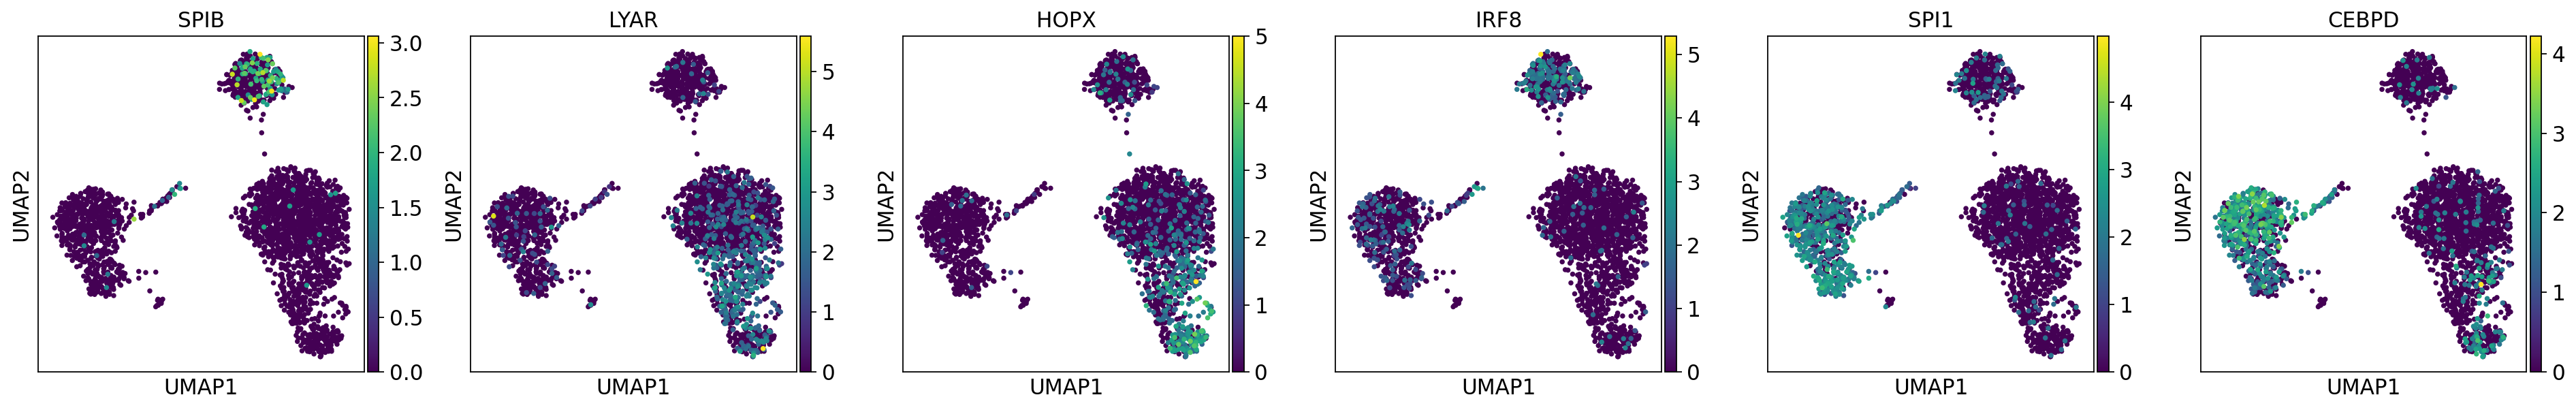

In [14]:
import matplotlib as mpl
TFs = ['SPIB', 'LYAR', 'HOPX', 'IRF8', 'SPI1', 'CEBPD']
sc.pl.umap(adata, color=TFs, ncols=6)

Dotplot of Gene expression in cell groups

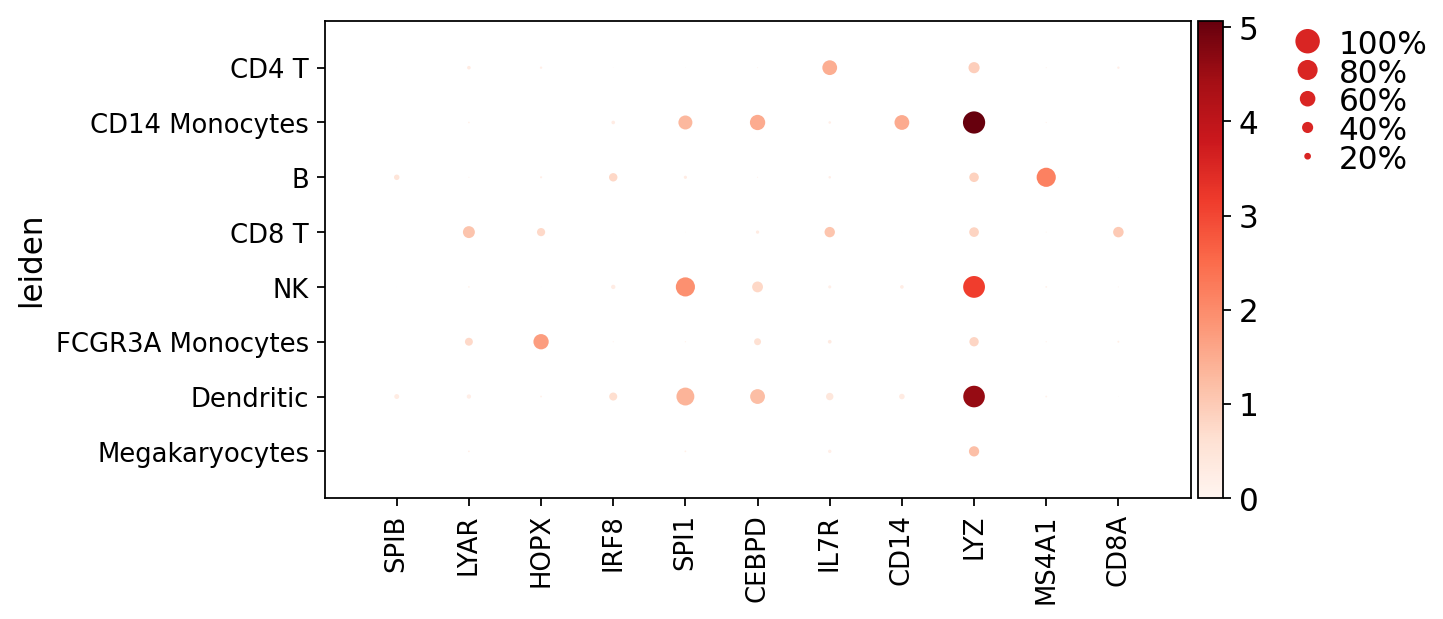

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.05, 0, 0.2, 0.5, 0.25])

In [15]:
marker_genes = ['SPIB', 'LYAR', 'HOPX', 'IRF8', 'SPI1', 'CEBPD', 'IL7R', 'CD14', 'LYZ', 'MS4A1', 'CD8A']
sc.pl.dotplot(adata, marker_genes, groupby='leiden', figsize=(8, 4), save=True)

With regard to identifying the master transcription factors dominantly regulating other genes, node centralities including degree, closeness, betweenness and pagerank were calculated and ranked. As shown below, the average rank of transcription factors for each cell type specific GRNs.

In [16]:
Marker_score = pd.DataFrame({'node': list(TFs)})
for cell in cells:
    tmp = pd.read_excel(file_path + cell + '_centrality.xlsx')
    print(cell)
    test = tmp[tmp.node.isin(TFs)]
    test.node = test.node.astype('category')
    test.node.cat.set_categories(TFs, inplace=True)
    print(test.sort_values('node')[['node', 'avg_rank']])
    Marker_score[cell] = list(test.sort_values('node').avg_rank)


B
      node  avg_rank
181   SPIB    165.75
132   LYAR      9.75
15    HOPX     71.75
186   IRF8    154.75
86    SPI1    123.00
43   CEBPD     97.00
CD4 T
      node  avg_rank
189   SPIB      2.00
15    LYAR    187.50
34    HOPX    148.75
98    IRF8     52.25
42    SPI1     28.25
88   CEBPD     99.50
CD8 T
      node  avg_rank
182   SPIB      7.25
178   LYAR    132.25
128   HOPX    108.25
107   IRF8     58.50
38    SPI1     40.75
58   CEBPD    167.50
CD14 Monocytes
      node  avg_rank
187   SPIB      7.75
168   LYAR     24.75
73    HOPX     45.75
160   IRF8    160.75
175   SPI1    125.50
101  CEBPD    134.50


Calculate the ratio of rank score of transcription factors in each cell types.

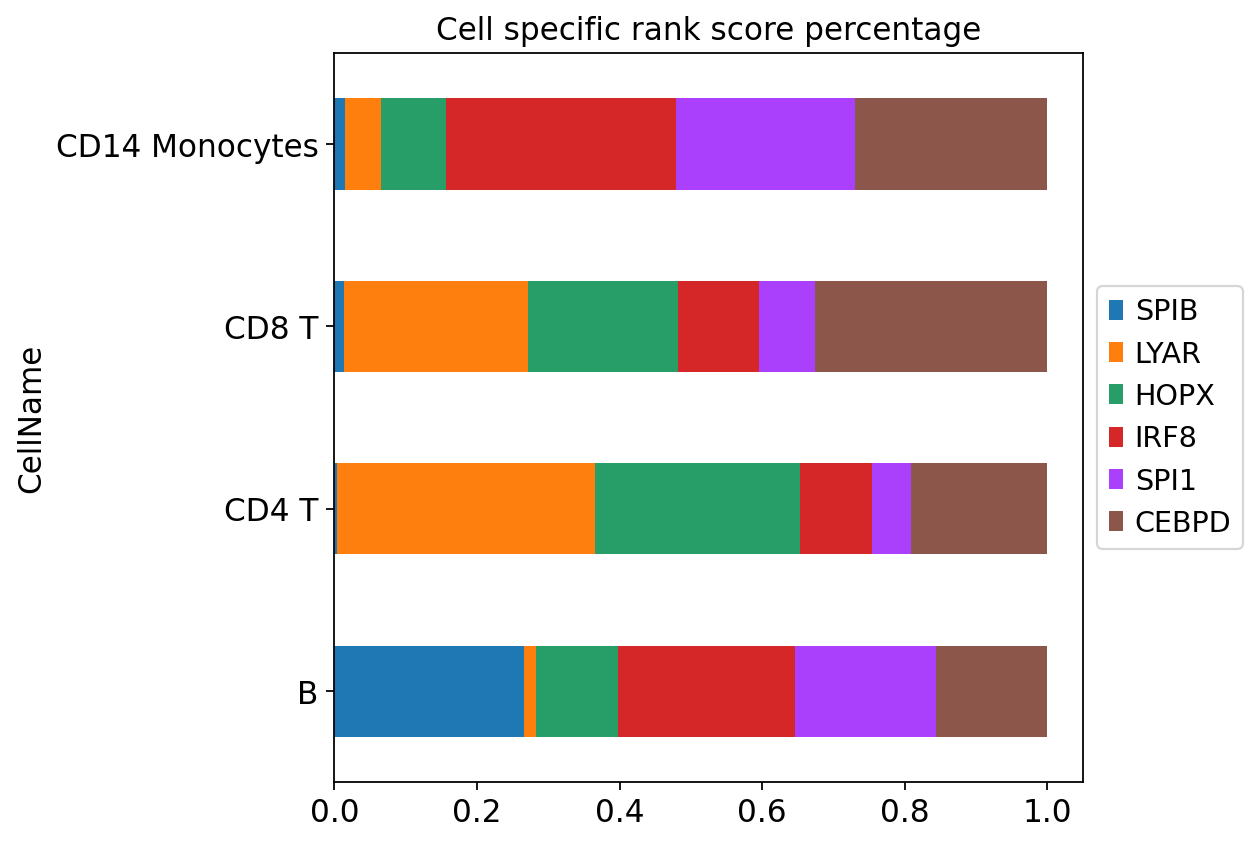

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


tmp = Marker_score.iloc[:, 1:]/Marker_score.iloc[:, 1:].sum(0)
tmp = tmp.T.reset_index()
tmp.columns = ['CellName'] + list(Marker_score.node)

tmp.plot( 
  x = 'CellName',  
  kind = 'barh',  
  stacked = True,  
  title = 'Cell specific rank score percentage',  
  mark_right = True,
 figsize = (6, 6)) 

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(b=None)
# plt.savefig(file_path + 'Marker_Percentage.pdf', dpi=300, bbox_inches='tight')


radar plots illustrating the cell specific and shared transcription factors.

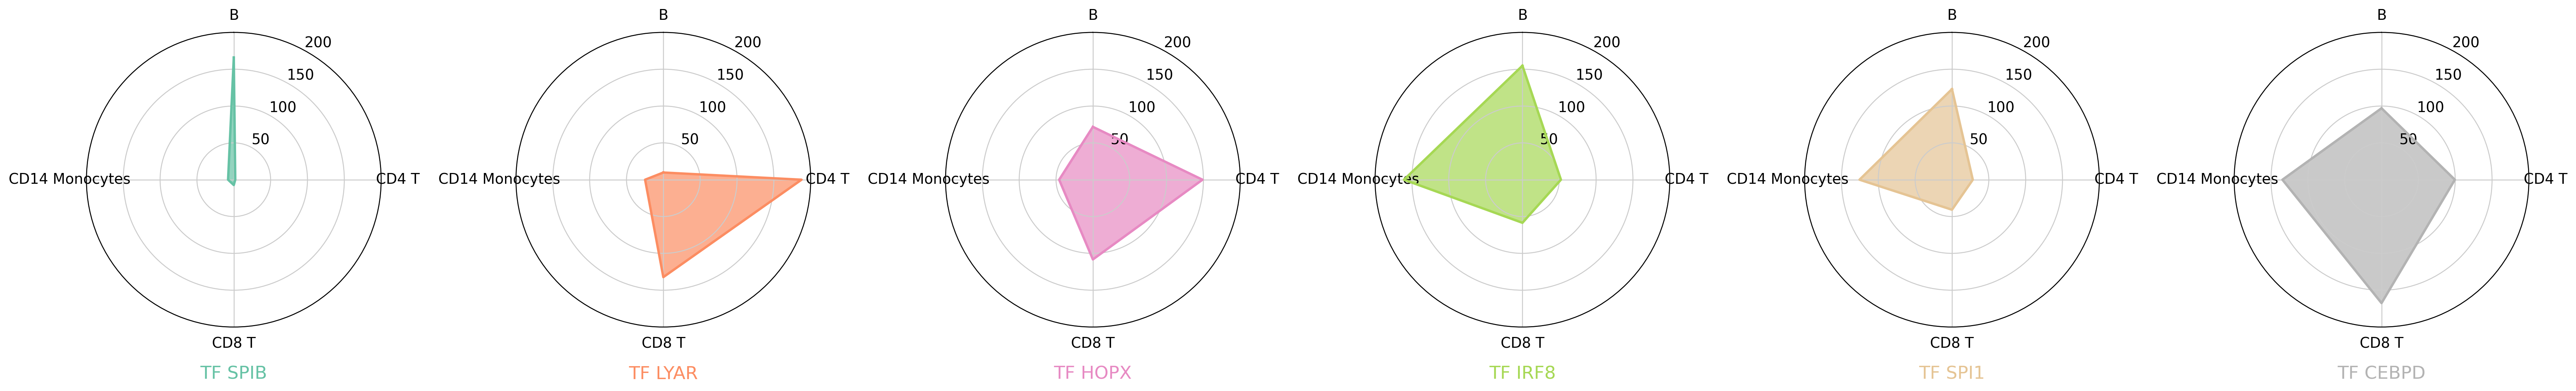

In [18]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi
df = Marker_score
def make_spider(row, title, color):
     
    categories=list(df)[1:]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax = plt.subplot(1,6,row+1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    plt.xticks(angles[:-1], categories, color='black', size=12, x=0.5)
    plt.yticks([50, 100, 150, 200], ["50","100","150", "200"], color="black", size=12, x=0.5)
    plt.ylim(0,200)

    values=df.loc[row].drop('node').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.7)

    
    plt.title(title, size=15, color=color, y=-0.2)

my_dpi=96
plt.figure(figsize=(30,80), dpi=120)

my_palette = plt.cm.get_cmap("Set2", len(df.index))
 

for row in list(df.index):
    make_spider(row=row, title='TF '+df['node'][row], color=my_palette(row))

plt.tight_layout()
# plt.savefig(file_path + 'Marker_Radar_Plot.pdf', bbox_inches='tight')


### NetEnrich: Graph travel and supervised random walk
NetEnrich module integretes graph traversal techniques to expolre gene regulatory network. It includes **Breadth-first search**, **Depth-first search** and **Supervised random walk**. In this way, gene trigger paths indicating genes with hidden associations can be predicted. 

In [19]:
path = ne.graph_traveral(scanpy_gne.NetAttrs['graph'], start='IRF8', threshold=2, method='bfs')


In [40]:
random_path = ne.self_guide_walk(scanpy_gne, start='CCL4', supervisedby='degree', steps=5)
random_path

['CCL4', 'TSPAN13', 'CST7', 'MATK', 'CTSW']

### Plotting: Network Visualization 

Create plotly-dash network in jupyter notebook. As shown below, top 100 consensus links were seleced for GRN construction. Nodes were colored by gene modules.

In [21]:
#scanpy_gne.NetAttrs['graph'] will be updated
new_app = pl.create_app(gnetdata=scanpy_gne, grn_method='consensus_links', top_links=100, resolution=0.6)
new_app

graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs


Alternatively, it can be shown as html page. 

In [22]:
pl.dynamic_netShow(scanpy_gne, filename='test.html')

The global veiew of the network can be illustrated as circle or matrix layout

(-0.8, 8.8, 9.9, -0.9)

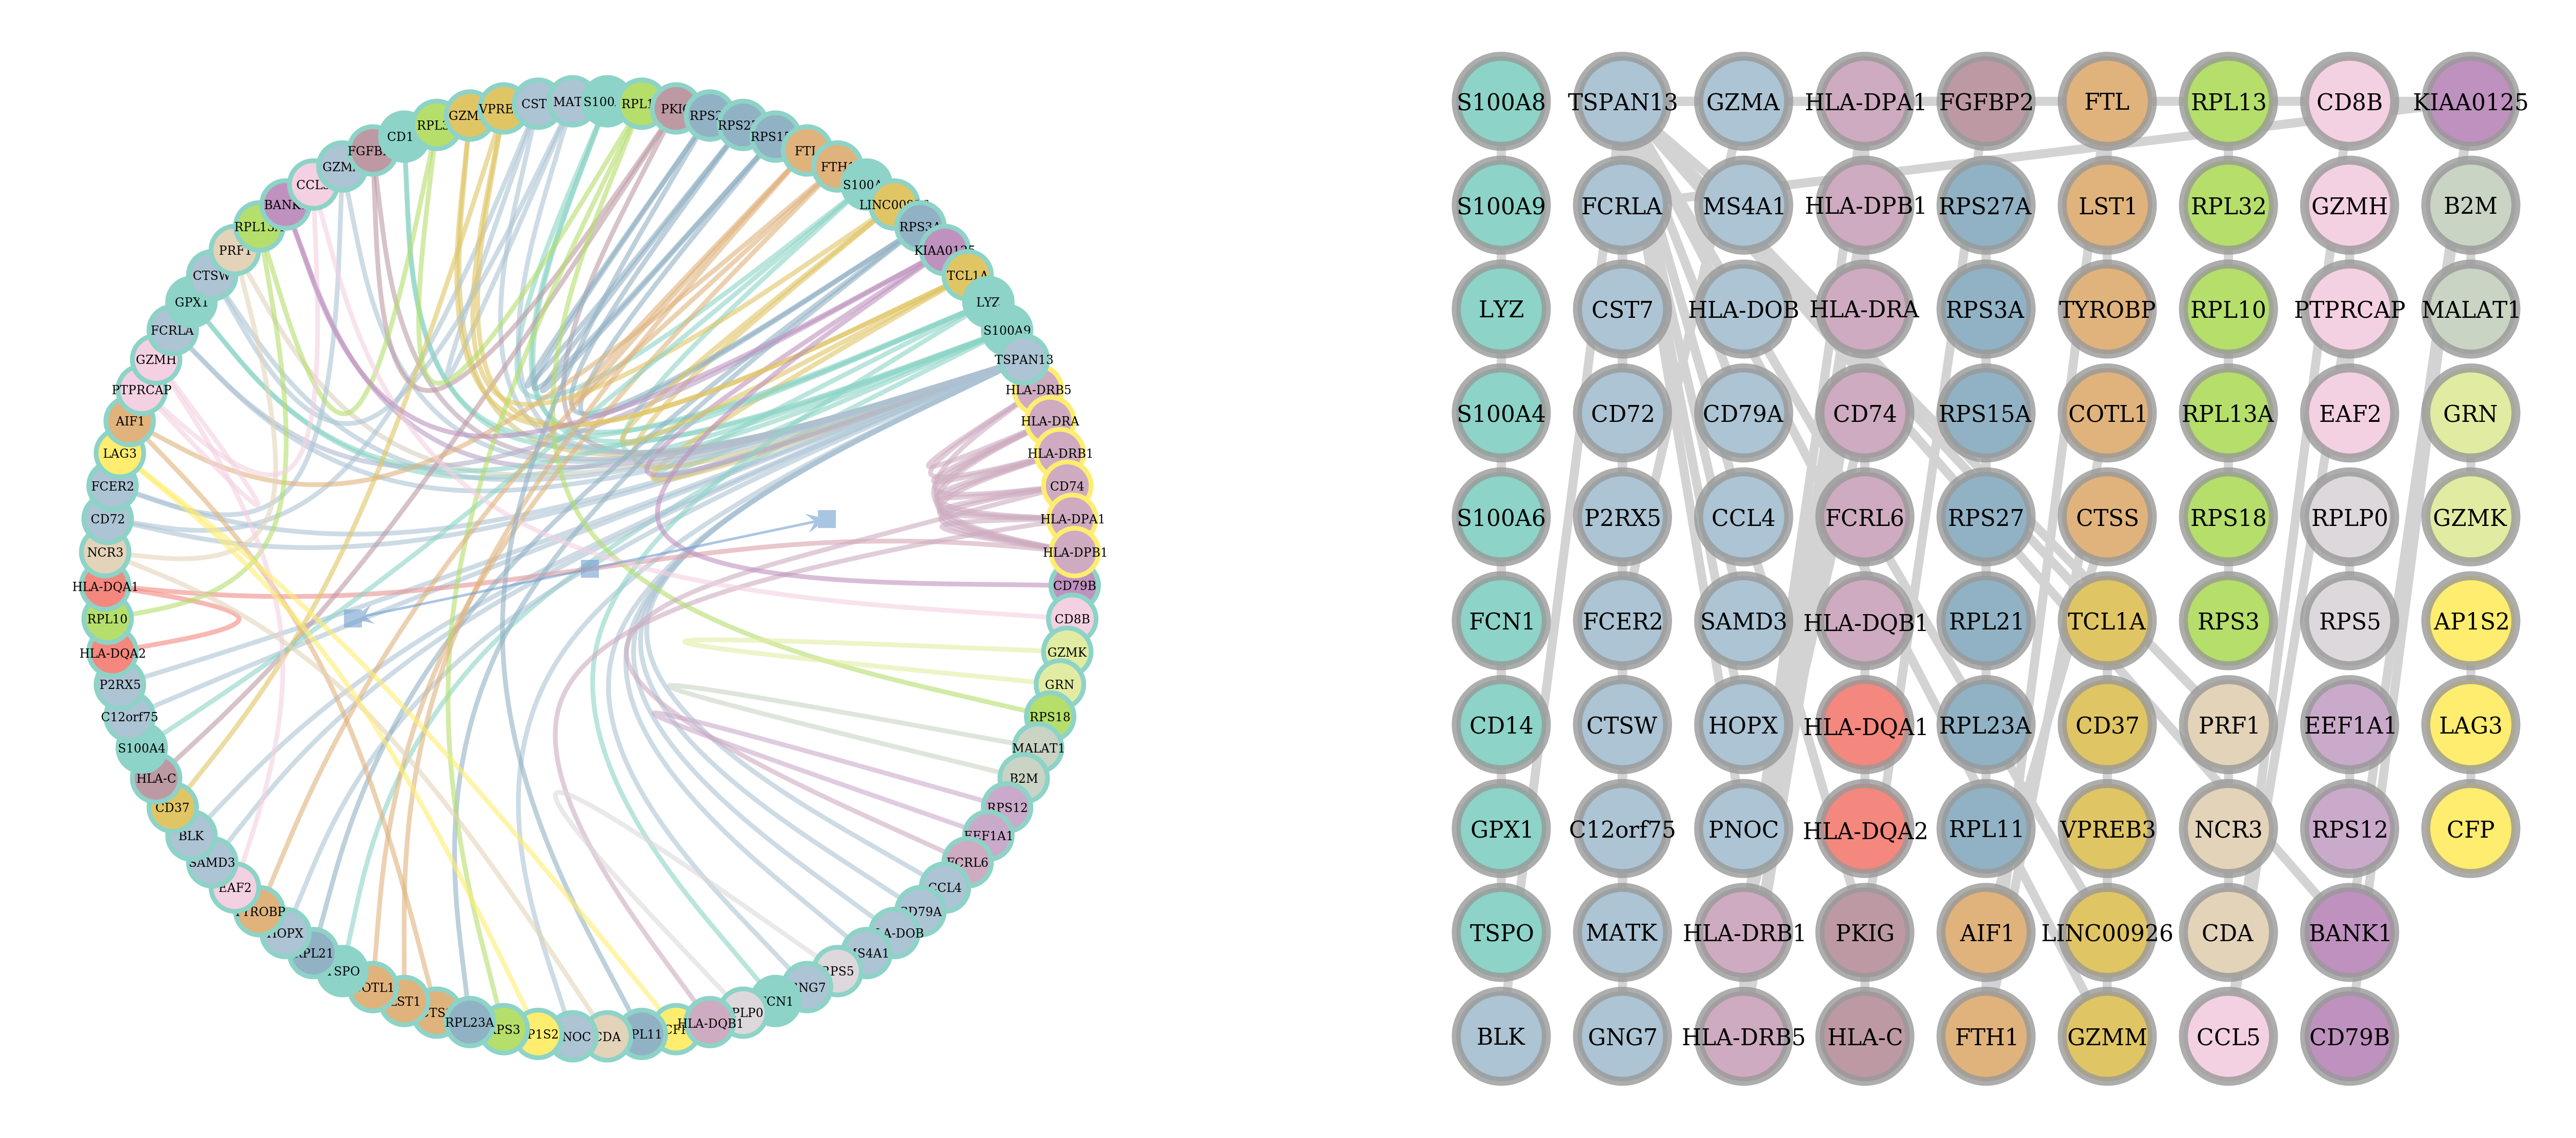

In [23]:
from pyscnet.Plotting import net_plot as npl
import matplotlib.pyplot as plt 
plt.switch_backend("cairo")
fig, ax = plt.subplots(1, 2, figsize=(40, 18))
# npl.net_matrix_plot(stream_gne, output_size=(500, 500), vertex_text_position=-2, vertex_font_size=5)
pl.net_hierarchy_plot(scanpy_gne, vertex_text_position=-2, vertex_size=0.2,  vertex_font_size=0.05, mplfig=ax[0])
pl.net_matrix_plot(scanpy_gne, vertex_text_position=-2, vertex_size=0.8,  vertex_font_size=0.2, mplfig=ax[1])
ax[0].axis('off')
ax[1].axis('off')

<AxesSubplot:>

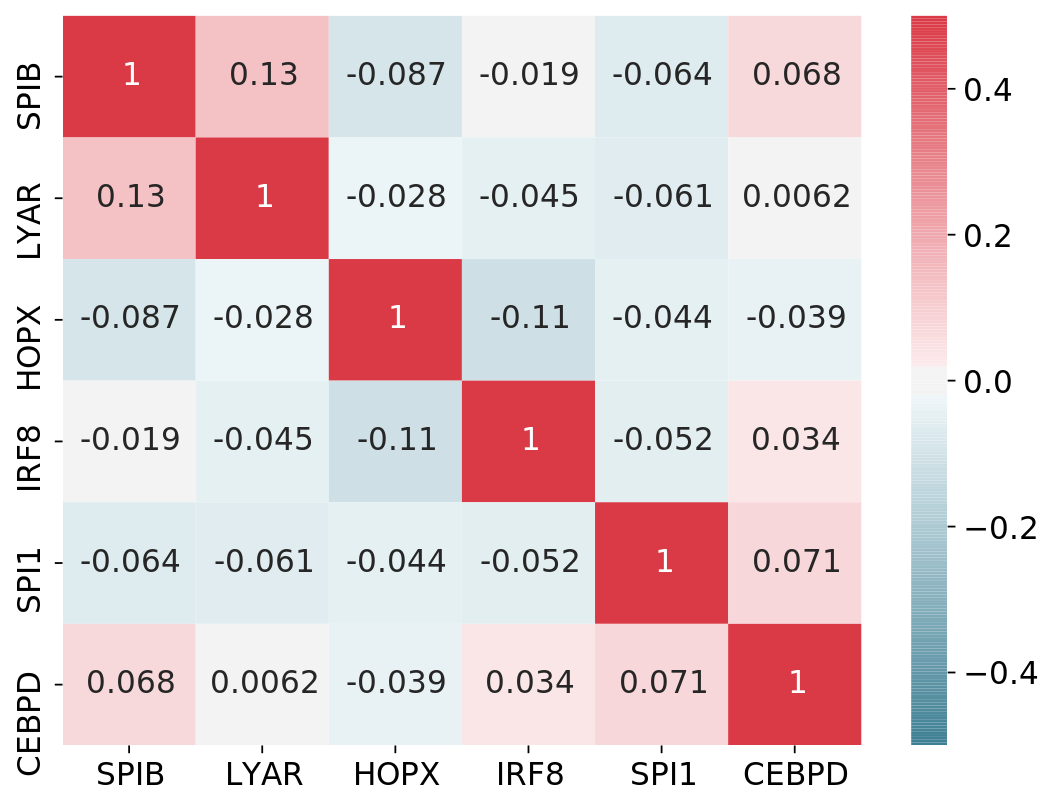

In [26]:
#correlation heatmap
pl.geneCorrelation(scanpy_gne, gene=TFs,
                cell_clusterid=('B'), select_by='leiden', order_by='total_counts',
                xticklabels=True, yticklabels=True,
                figsize=[8, 6], vmax=0.5, vmin=-0.5, annot=True)

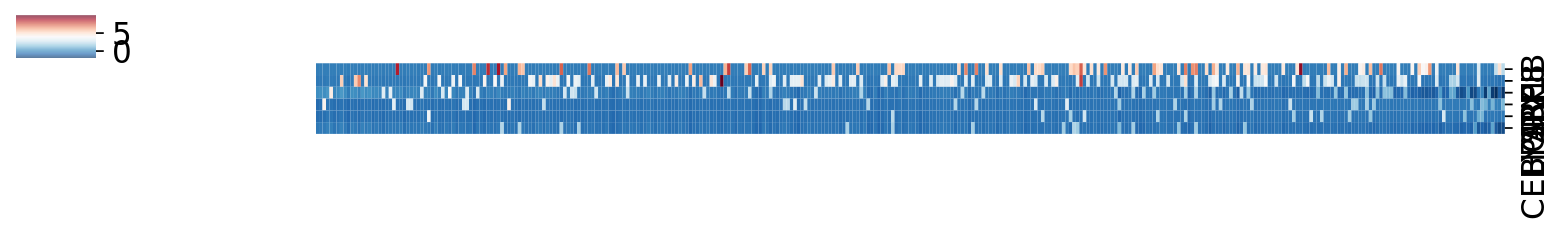

In [25]:
# gene expression heatmap
cg = pl.geneHeatmap(scanpy_gne, gene=TFs,figsize=[10,1.5], 
                    cell_clusterid=('B'), select_by='leiden', order_by='total_counts', 
                    yticklabels=True,
                    col_cluster=False, cmap='RdBu_r')

cg.ax_row_dendrogram.set_visible(False)